# 13. Cluster Analysis

[AJ Smit](https://ajsmit.netlify.app)
[](https://orcid.org/0000-0002-3799-6126)
([University of the Western Cape](https://uwc.ac.za))  
2021-01-01

> “*There are two types of people in the world: 1) those who extrapolate
> from incomplete data.*”
>
> – Anon.

## Introduction

We have seen that the WHO/SDG data seem to form neat groupings of
countries within their respective parent locations. In this exercise we
will apply a cluster analysis called ‘Partitioning Around Medoids’ to
these data. Whereas ordination attempts to display the presence and
influence of gradients, clustering tries to place our samples into a
certain number of discrete units or clusters. The goal of the clustering
algorithms is to produce groups (clusters) such that dissimilarities
between objects within these groups are smaller than those between them.

My reading of the ecological literature suggests that cluster analysis
is far less common than ordination, unless you’re an ecologist with
conservationist tendencies. If this is a true observation, why would it
be? This is also the reason why I spend less time in this module on
cluster analysis, but it is nevertheless a tool that you should be
familiar with. Sometimes clustering techniques are combined with
ordinations (particularly PCA), in which case they can be quite powerful
and insightful.

Broadly speaking, clustering algorithms can be divided into
[‘hierarchical agglomerative
classification’](https://www.davidzeleny.net/anadat-r/doku.php/en:hier-agglom_r)
and [non-hierarchical classification
(e.g. K-means)](https://www.davidzeleny.net/anadat-r/doku.php/en:non-hier_r).
Numerical Ecology in R provides more information about the various kinds
of classifications and makes the following distinctions of
classification methods: ‘sequential or simultaneous,’ ‘agglomerative or
divisive,’ ‘monothetic versus polythetic,’ ‘hierarchical versus
non-hierarchical methods,’ ‘probabilistic versus non-probabilistic,’ and
‘fuzzy’ methods. Regardless of how one classifies the classification
algorithms, they are well-represented in R. The workhorse cluster
analysis package in R is, strangely, called **cluster**. The function we
will use in this example is called `pam()` but several other functions
are also available, most notably ‘Agglomerative Nesting (Hierarchical
Clustering)’ called by `agnes()`, ‘DIvisive ANAlysis Clustering’ by
`diana()`, and ‘Fuzzy Analysis Clustering’ by `fanny()`. The `kmeans()`
and `hclust()` functions in base R are also available and frequently
used by ecologists. Of course, there is also the old faithful
[TWINSPAN](https://github.com/jarioksa/twinspan) which has been ported
to R that might be of interest still, and
[IndVal](https://doi.org/10.1016/B978-0-12-384719-5.00430-5), which is a
modern replacement for TWINSPAN. All of the cluster analyses functions
come with their own plotting methods, and you should become familiar
with them.

The package **factoextra** provides useful helper functions for cluster
analysis, and also provides clustering functions that can be used *in
lieu* of the ones mentioned above.

For examples of clustering, please refer to:

1.  Numerical Ecology in R, pp. 53-62. Later pages in the Cluster
    Analysis chapter go deeper into clustering and you should read over
    it for a broad overview. For the purpose of this module, we will
    focus on 4.3 Hierarchical Clustering and 4.4 Agglomerative
    Clustering.
2.  A [Kaggle
    challenge](https://www.kaggle.com/davimattar/help-international-clustering-using-r)
    with examples of both Hierarchical Clustering and K-means
    Clustering.
3.  The `iris` dataset is an excellent dataset to practice cluster
    analysis on; in fact, cluster analysis examples of this dataset are
    common on the internet.

Let’s explore the WHO/SDG dataset usig the `pam()` function.

## Set-up the analysis environment

In [ ]:
library(tidyverse) 
library(cluster)
library(ggcorrplot)
library(factoextra)
library(vegan)
library(ggpubr)

# setting up a 'root' file path so I don't have to keep doing it later...
root <- "../data/"

## Load the SDG data

I load the combined dataset that already had their missing values
imputed (as per the
[PCA](https://github.com/ajsmit/Quantitative_Ecology/blob/main/jupyter_lab/Topic_8-PCA-SDG-example.ipynb)
example).

In [ ]:
SDGs <- read_csv(paste0(root, "WHO/SDG_complete.csv"))
SDGs[1:5, 1:8]

# A tibble: 5 × 8
  ParentLocation       Location other_1 other_2 SDG1.a SDG16.1 SDG3.1_1 SDG3.2_1
  <chr>                <chr>      <dbl>   <dbl>  <dbl>   <dbl>    <dbl>    <dbl>
1 Eastern Mediterrane… Afghani…    61.6    15.6   2.14    9.02      673   135.  
2 Europe               Albania     77.8    21.1   9.62    3.78       16     7.55
3 Africa               Algeria     76.5    21.8  10.7     1.66      113    38.0 
4 Africa               Angola      61.7    16.7   5.43    9.82      246   125.  
5 Americas             Antigua…    76.1    20.4  11.6     2.42       43     5.94

The parent locations:

In [ ]:
unique(SDGs$ParentLocation)

[1] "Eastern Mediterranean" "Europe"                "Africa"               
[4] "Americas"              "Western Pacific"       "South-East Asia"      

The number of countries:

In [ ]:
length(SDGs$Location)

[1] 176

As is often the case with measured variables, we can start our
exploration with a correlation analysis to see the extent to which
correlation between variable pairs is present:

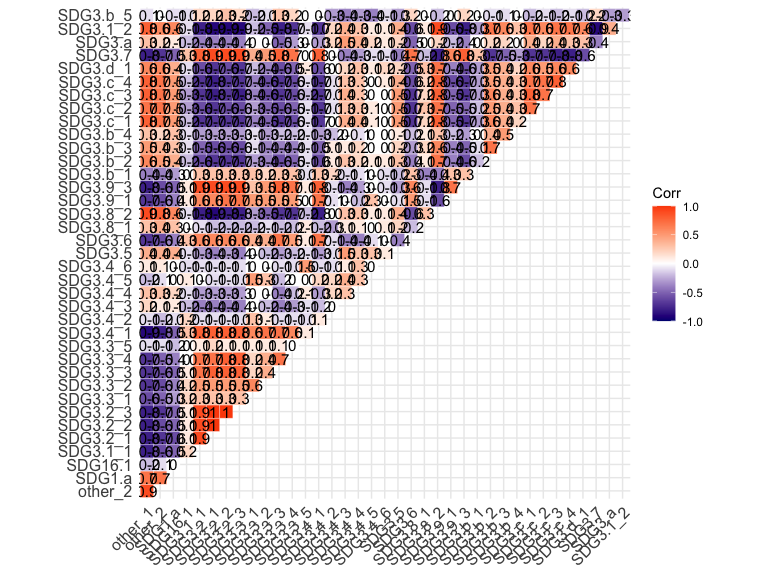

In [ ]:
# a correalation matrix
corr <- round(cor(SDGs[3:ncol(SDGs)]), 1)
ggcorrplot(corr, type = 'upper', outline.col = "white", 
           colors = c("navy", "white", "#FC4E07"), 
           lab = TRUE)

We might decide to remove collinear variables. A useful approach to use
here might be to look at the strongest loadings along the significant
reduced axes in a PCA and exclude the others, or find the ones most
strongly correlated as seen in the biplots—how you do this can be
rationalised on a case-by-case basis. I proceed with the full dataset,
but this is not ideal.

We need to standardise first to account for the different measurement
scales of the variables. We can calculate Euclidian distances before
running `pam()`, but it can also be specified within the function call.
We do the latter:

In [ ]:
SDGs_std <- decostand(SDGs[3:ncol(SDGs)], method = "standardize")
# SDGs_euc <- vegdist(SDGs_std, method = "euclidian")
rownames(SDGs_std) <- SDGs$Location # carry location names into output

The frustrating thing with cluster analysis, which often confuses novice
users, is that there is often an expectation that the clustering
alorithm decides for the user how many clusters to use. However, this is
a misconception that must be overcome. Although some numerical guidance
can be obtained through ‘silhouette,’ ‘within cluster sum of squares’ or
‘elbow’ analysis, and ‘gap statistic’, in my experience they are no
substitute for the power of human reasoning. Let us see what the
**factoextra** package function `fviz_nbclust()` tell us about how many
group to use:

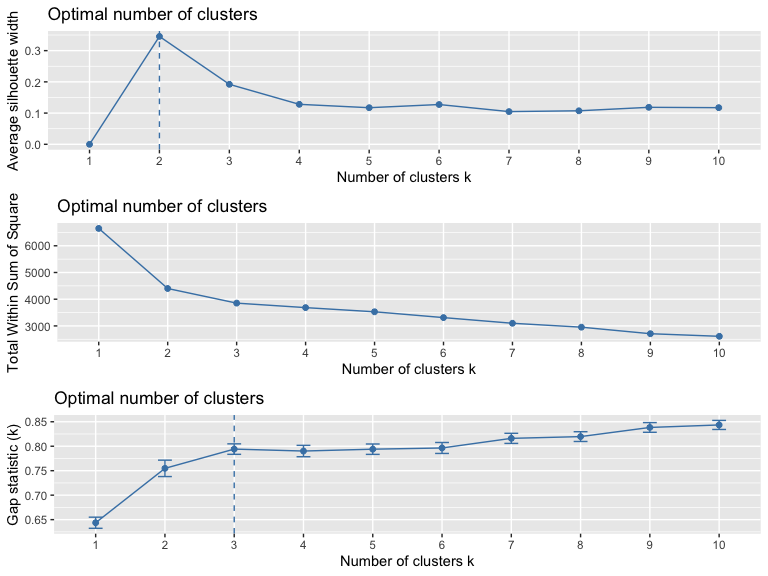

In [ ]:
# using silhouette analysis
plt1 <- fviz_nbclust(SDGs_std, cluster::pam, method = "silhouette") + 
  theme_grey()

# total within cluster sum of square / elbow analysis
plt2 <- fviz_nbclust(SDGs_std, cluster::pam, method = "wss") + 
  theme_grey()

# gap statistics
plt3 <- fviz_nbclust(SDGs_std, cluster::pam, method = "gap_stat") + 
  theme_grey()

ggarrange(plt1, plt2, plt3, nrow = 3)

Even with the supposedly objective assessment of what the optimal number
of clusters should be, we see that each method still provides a
different result. Much better to proceed with expert knowledge about the
nature of the data and the intent of the study. Let us proceed with
three clusters as I think two clusters are insufficient for our purpose.

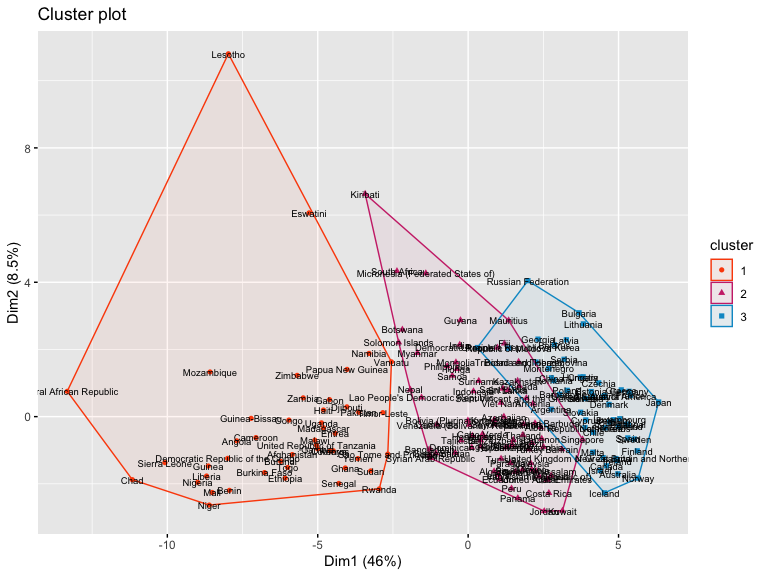

In [ ]:
SDGs_pam <- pam(SDGs_std, metric = "euclidean", k = 3)

fviz_cluster(SDGs_pam, geom = "point", ellipse.type = "convex",
             palette = c("#FC4E07", "violetred3", "deepskyblue3"),
             ellipse.alpha = 0.05) +
  geom_text(aes(label = SDGs$Location), size = 2.5)

We cannot clearly see where SA is, so let’s create a clearer plot:

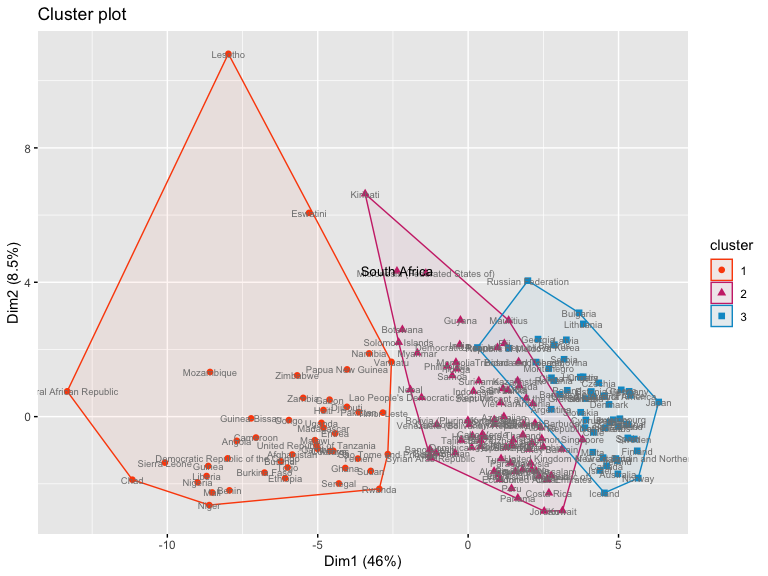

In [ ]:
# scale SA bigger for plotting
SDGs <- SDGs |> 
  mutate(col_vec = ifelse(Location == "South Africa", "black", "grey50"),
         scale_vec = ifelse(Location == "South Africa", 3.5, 2.5))

fviz_cluster(SDGs_pam, geom = "point", ellipse.type = "convex",
             palette = c("#FC4E07", "violetred3", "deepskyblue3"),
             ellipse.alpha = 0.05, pointsize = 2.0) +
  geom_text(aes(label = SDGs$Location), size = SDGs$scale_vec, col = SDGs$col_vec)

Note that `pam()`, unlike hierarchical or agglomerative clustering, does
not produce a dendrogram and the usual way to graphically present the
cluster arrangement is to create a scatter plot similar to an ordination
diagramme (but it is NOT an ordination diagram).

Same as above, but showing a star plot and numbers indicating the
countries (their row numbers in `SDGs`):

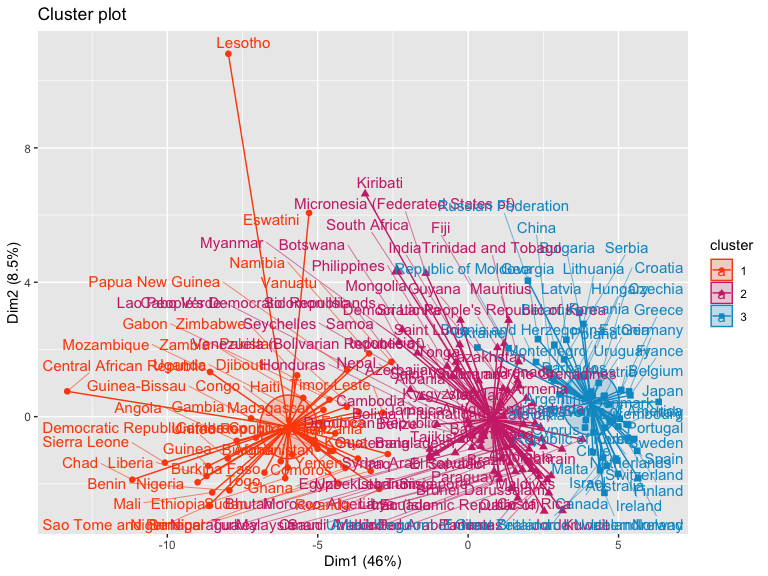

In [ ]:
fviz_cluster(SDGs_pam, palette = c("#FC4E07", "violetred3", "deepskyblue3"),
             ellipse.type = "euclid", star.plot = TRUE, repel = TRUE,
             pointsize = SDGs$scale_vec * 0.8) + # SA plotted slightly bigger
  theme_grey()

Do a silhouette analysis to check cluster fidelity:

  cluster size ave.sil.width
1       1   46          0.27
2       2   78          0.09
3       3   52          0.27

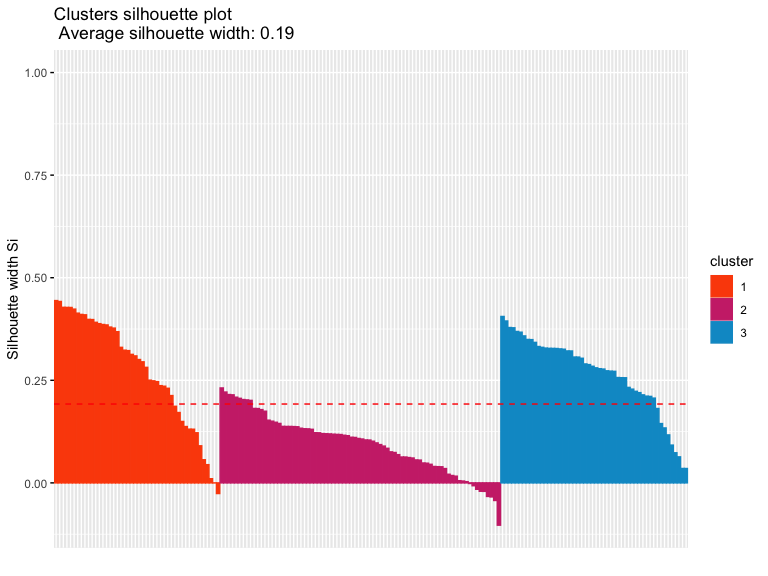

In [ ]:
fviz_silhouette(SDGs_pam, palette = c("#FC4E07", "violetred3", "deepskyblue3"),
                ggtheme = theme_grey())

Once happy with the number of clusters, find the median value for each
cluster:

In [ ]:
SDGs_centroids <- SDGs |> 
  mutate(cluster = SDGs_pam$clustering) |> 
  group_by(cluster) |> 
  summarise_at(vars(other_1:SDG3.b_5), median, na.rm = TRUE)
SDGs_centroids

# A tibble: 3 × 39
  cluster other_1 other_2 SDG1.a SDG16.1 SDG3.1_1 SDG3.2_1 SDG3.2_2 SDG3.2_3
    <int>   <dbl>   <dbl>  <dbl>   <dbl>    <dbl>    <dbl>    <dbl>    <dbl>
1       1    62.4    16.7   5.43    8.88      396    90.0    214.     152.  
2       2    73.2    19.6   9.64    4.4        60    19.8     33.9     28.1 
3       3    80.4    23.2  13.3     1.28        7     2.78     4.73     4.00
# ℹ 30 more variables: SDG3.3_1 <dbl>, SDG3.3_2 <dbl>, SDG3.3_3 <dbl>,
#   SDG3.3_4 <dbl>, SDG3.3_5 <dbl>, SDG3.4_1 <dbl>, SDG3.4_2 <dbl>,
#   SDG3.4_3 <dbl>, SDG3.4_4 <dbl>, SDG3.4_5 <dbl>, SDG3.4_6 <dbl>,
#   SDG3.5 <dbl>, SDG3.6 <dbl>, SDG3.8_1 <dbl>, SDG3.8_2 <dbl>, SDG3.9_1 <dbl>,
#   SDG3.9_3 <dbl>, SDG3.b_1 <dbl>, SDG3.b_2 <dbl>, SDG3.b_3 <dbl>,
#   SDG3.b_4 <dbl>, SDG3.c_1 <dbl>, SDG3.c_2 <dbl>, SDG3.c_3 <dbl>,
#   SDG3.c_4 <dbl>, SDG3.d_1 <dbl>, SDG3.7 <dbl>, SDG3.a <dbl>, …

`pam()` can also provide the most representative example countries of
each cluster. Note that the values inside are very different from that
produced when we calculated the medians because `medoids` report the
standardised data:

In [ ]:
SDGs_pam$medoids

             other_1     other_2     SDG1.a     SDG16.1   SDG3.1_1   SDG3.2_1
Togo      -1.3082283 -1.04437853 -1.1903643  0.06808945  1.1324894  1.3017843
Nicaragua  0.3737688  0.08872107  1.3796506  0.08533933 -0.2323864 -0.2586716
Czechia    0.8823411  0.61551298  0.8833042 -0.64737012 -0.6765494 -0.8435034
            SDG3.2_2   SDG3.2_3   SDG3.3_1   SDG3.3_2   SDG3.3_3   SDG3.3_4
Togo       1.4102734  1.3592849  0.1576964 -0.4579343  2.4882232  1.2835322
Nicaragua -0.3767895 -0.3446689 -0.3154270 -0.4579343 -0.1580909 -0.6637395
Czechia   -0.7133630 -0.7745694 -0.1376945 -0.7136379 -0.9480541 -0.5125539
             SDG3.3_5   SDG3.4_1   SDG3.4_2   SDG3.4_3   SDG3.4_4    SDG3.4_5
Togo      -0.06030043  1.2520369 -0.4762540 -0.6960758 -0.6952419 -0.07418662
Nicaragua -0.16897721 -0.1601567  0.4796550 -0.5087310 -0.2996050 -0.62139368
Czechia   -0.18762124 -0.9262184  0.1254489  1.1464418  0.3787484  0.33180571
            SDG3.4_6     SDG3.5      SDG3.6   SDG3.8_1   SDG3.8_2   SDG3

We can do a coloured pairwise scatterplot to check data details. I limit
it here to the pairs of the first 7 columns because of the large number
of possible combinations:

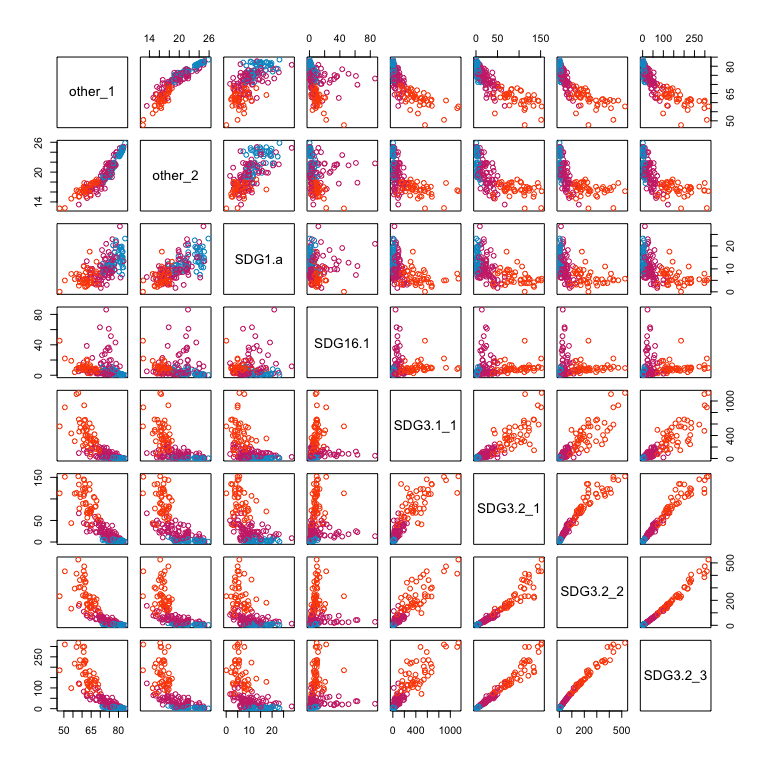

In [ ]:
pairs(SDGs[, 3:10],
      col = c("#FC4E07", "violetred3", "deepskyblue3")[SDGs_pam$clustering])

> **Lab 4 (continue)**
>
> **These questions are a continuation of Lab 4 in the [Principal
> Analysis Section (SDGs)](08-PCA_SDG.qmd) section; refer to that
> section for additional questions to submit together with this
> analysis.** This is the final set of questions for Quantitative
> Ecology.
>
> 1.  What happens if we use `pam()` to create four, five, or even six
>     clusters?
>
> 2.  In your reasoned opinion, what would be the optimal number of
>     clusters to use?
>
> 3.  Repeat the analysis using either `kmeans()` or `hclust()`, and
>     feel free to use the **factoextra** helper functions and
>     visualisations. Are the results markedly different? Which
>     clustering approach do you wish to proceed with—i.e., `pam()`,
>     `hclust()` or `kmeans()`?
>
> 4.  Describe the patterns that you observe at the end of your
>     ordination and final cluster selection (i.e. based on the optimal
>     number of clusters and whichever cluster technique you deem most
>     appropriate). How does South Africa fare in terms of attaining
>     SDGs? Contrast with some key countries of your choice to make your
>     points. Label the key countries that you refer to in your text by
>     updating the code accordingly. Continue to explain these patterns
>     in terms of the global socio-political/socio-economic landscape.
>     Provide a discourse about possible explanations for the patterns
>     observed globally and regionally.

> **Submission instructions**
>
> The deadline for this submission is Monday x August 2022.
>
> Provide a **neat and thoroughly annotated** Rmarkdown file which
> outlines the graphs and all calculations and which displays the
> resultant distance matrix. Use separate tabs for the different
> questions.
>
> Please label the Rmarkdown and resulting HTML files as follows:
>
> -   `BCB743_<first_name>_<last_name>_Lab_4.Rmd`, and
>
> -   `BCB743_<first_name>_<last_name>_Lab_4.html`
>
> (the `<` and `>` must be omitted as they are used in the example as
> field indicators only).
>
> Failing to follow these instructions carefully, precisely, and
> thoroughly will cause you to lose marks, which could cause a
> significant drop in your score as formatting counts for 15% of the
> final mark (out of 100%).
>
> Submit your Labs on iKamva when ready.

## References